## RQ1: How relevant is the topic?

## Results using data until 2023

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV files
github_actions_df = pd.read_csv(f'..\RQ1_Relevance\data\github-actions.csv')
jenkins_df = pd.read_csv(f'..\RQ1_Relevance\data\jenkins.csv')
gitlab_ci_df = pd.read_csv(f'..\RQ1_Relevance\data\gitlab-ci.csv')
azure_devops_df = pd.read_csv(f'..\RQ1_Relevance\data\\azure-devops.csv')
circleci_df = pd.read_csv(f'..\RQ1_Relevance\data\circleci.csv')
travis_ci_df = pd.read_csv(f'..\RQ1_Relevance\data\\travis-ci.csv')  

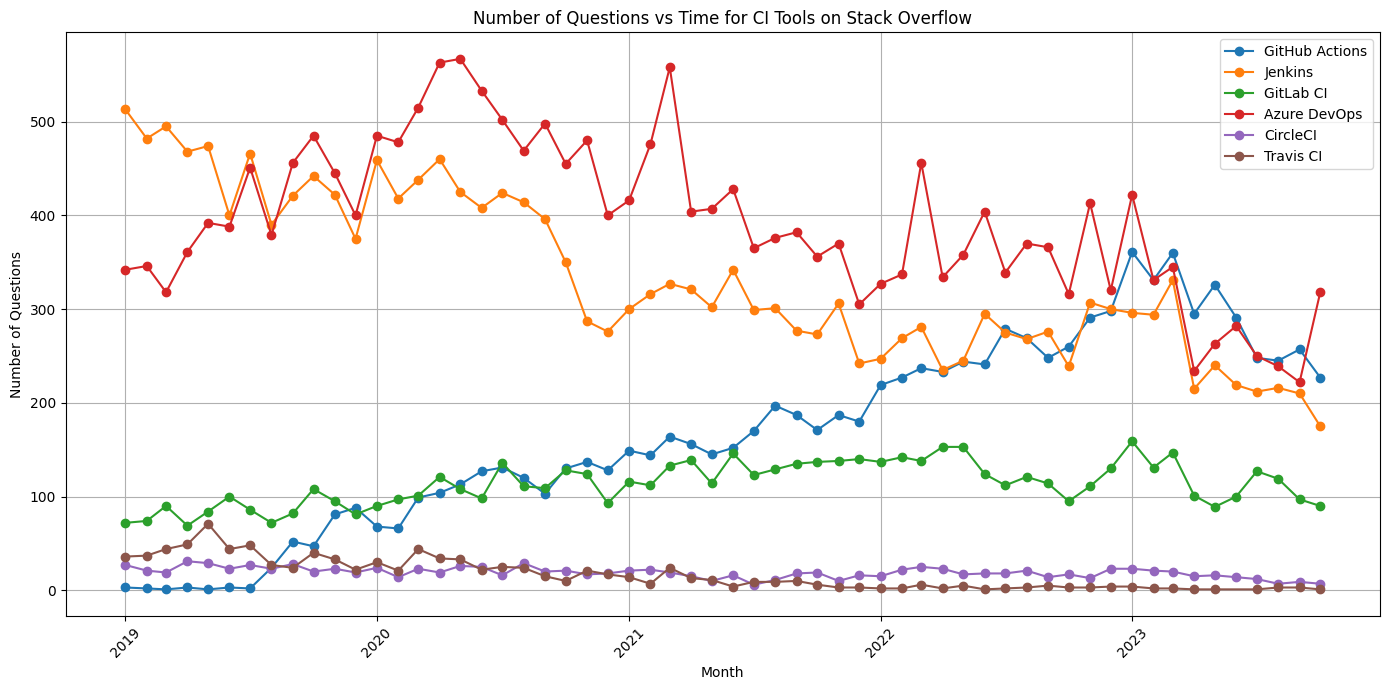

In [8]:

github_actions_df['Month'] = pd.to_datetime(github_actions_df['Month'])
jenkins_df['Month'] = pd.to_datetime(jenkins_df['Month'])
gitlab_ci_df['Month'] = pd.to_datetime(gitlab_ci_df['Month'])
azure_devops_df['Month'] = pd.to_datetime(azure_devops_df['Month'])
circleci_df['Month'] = pd.to_datetime(circleci_df['Month'])
travis_ci_df['Month'] = pd.to_datetime(travis_ci_df['Month'])  

# Plotting
plt.figure(figsize=(14, 7))

# Plot each CI tool's data
plt.plot(github_actions_df['Month'], github_actions_df['NumberOfQuestions'], label='GitHub Actions', marker='o')
plt.plot(jenkins_df['Month'], jenkins_df['NumberOfQuestions'], label='Jenkins', marker='o')
plt.plot(gitlab_ci_df['Month'], gitlab_ci_df['NumberOfQuestions'], label='GitLab CI', marker='o')
plt.plot(azure_devops_df['Month'], azure_devops_df['NumberOfQuestions'], label='Azure DevOps', marker='o')
plt.plot(circleci_df['Month'], circleci_df['NumberOfQuestions'], label='CircleCI', marker='o')
plt.plot(travis_ci_df['Month'], travis_ci_df['NumberOfQuestions'], label='Travis CI', marker='o')  # This is not provided, hence commented out.

# Formatting the plot
plt.xlabel('Month')
plt.ylabel('Number of Questions')
plt.title('Number of Questions vs Time for CI Tools on Stack Overflow')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping

# Show the plot
plt.show()


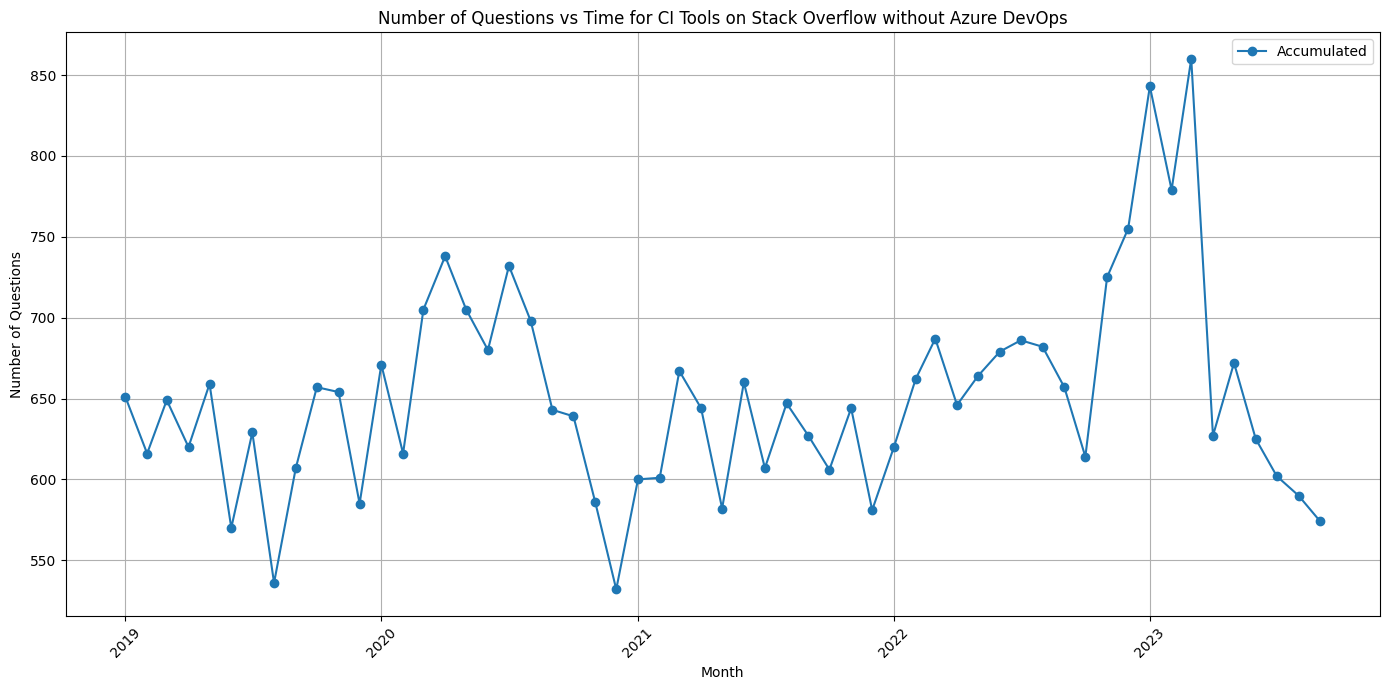

In [9]:
accumulated_df = pd.DataFrame()
accumulated_df['Month'] = github_actions_df['Month']
accumulated_df['NumberOfQuestions'] = github_actions_df['NumberOfQuestions'] + jenkins_df['NumberOfQuestions'] + gitlab_ci_df['NumberOfQuestions'] + azure_devops_df['NumberOfQuestions'] + circleci_df['NumberOfQuestions'] + travis_ci_df['NumberOfQuestions']
accumulated_df['NumberOfQuestions'] = github_actions_df['NumberOfQuestions'] + jenkins_df['NumberOfQuestions'] + gitlab_ci_df['NumberOfQuestions'] + circleci_df['NumberOfQuestions'] + travis_ci_df['NumberOfQuestions']

plt.figure(figsize=(14, 7))
plt.plot(accumulated_df['Month'], accumulated_df['NumberOfQuestions'], label='Accumulated', marker='o')
# Formatting the plot
plt.xlabel('Month')
plt.ylabel('Number of Questions')
plt.title('Number of Questions vs Time for CI Tools on Stack Overflow without Azure DevOps')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout() 

# Show the plot
plt.show()

In [10]:
# Total number of SO posts for each ci tool

print(github_actions_df['NumberOfQuestions'].sum())
print(jenkins_df['NumberOfQuestions'].sum())
print(gitlab_ci_df['NumberOfQuestions'].sum())
print(azure_devops_df['NumberOfQuestions'].sum())
print(circleci_df['NumberOfQuestions'].sum())
print(travis_ci_df['NumberOfQuestions'].sum())

9622
19354
6581
22797
1095
940


## Results using data until 2024

                   avg_view  avg_fav  avg_score   avg_ans  avg_answer_score  \
github-actions  2787.936568      NaN   3.009667  1.008562               NaN   
jenkins         1505.136625      NaN   0.798640  0.935013               NaN   
gitlab-ci       2779.479487      NaN   1.918234  1.036182               NaN   
azure-devops    1996.889643      NaN   1.293948  1.222340               NaN   
travis-ci       1250.567021      NaN   1.540426  0.975532               NaN   
circleci        1333.616943      NaN   1.479742  0.967772               NaN   

                answers_per_question  unanswered_question_ratio  \
github-actions              1.008562                   0.286411   
jenkins                     0.935013                   0.272846   
gitlab-ci                   1.036182                   0.239601   
azure-devops                1.222340                   0.111413   
travis-ci                   0.975532                   0.248936   
circleci                    0.967772        

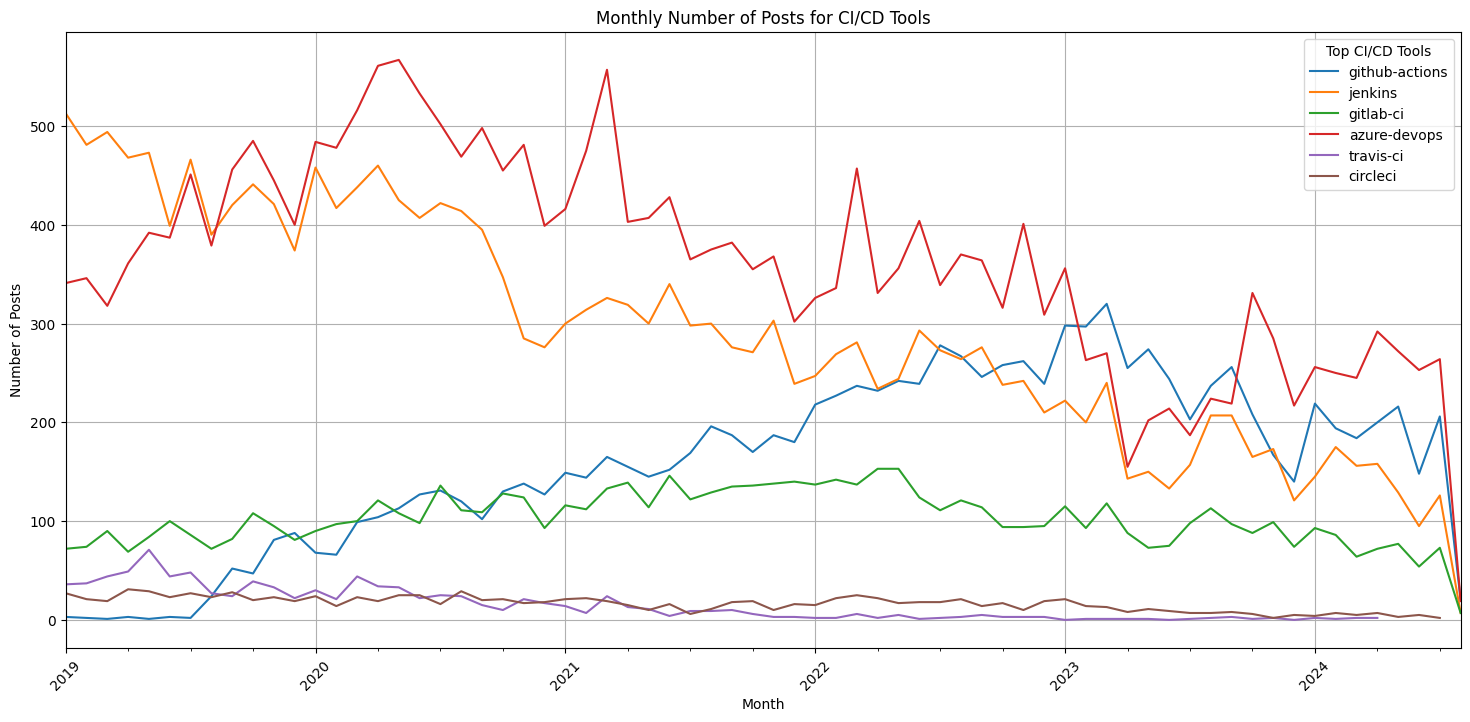

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the three datasets
df_2019_2020 = pd.read_csv(f'..\RQ1_Relevance\data\cicd_tools_stackoverflow_2019_2020.csv')
df_2021_2022 = pd.read_csv(f'..\RQ1_Relevance\data\cicd_tools_stackoverflow_2021_2022.csv')
df_2023_2024 = pd.read_csv(f'..\RQ1_Relevance\data\cicd_tools_stackoverflow_2023_2024.csv')

# Combine the datasets into a single DataFrame
df = pd.concat([df_2019_2020, df_2021_2022, df_2023_2024])

# Convert CreationDate to datetime
df['CreationDate'] = pd.to_datetime(df['CreationDate'])

# List of CI/CD tools
cicd_tools = ['github-actions', 'jenkins', 'gitlab-ci', 'azure-devops', 'travis-ci', 'circleci']

# Initialize a dictionary to store the results
results = {}
monthly_posts_data = {}

for tool in cicd_tools:
    # print(f"Analyzing data for {tool}...")
    
    # Filter data for the current tool
    tool_df = df[df['TagName'] == tool]
    
    # Separate questions and answers
    questions = tool_df[tool_df['PostTypeId'] == 1].copy()
    answers = tool_df[tool_df['PostTypeId'] == 2].copy()

    # Calculate Metrics
    avg_view = questions['ViewCount'].mean()
    avg_fav = questions['FavoriteCount'].mean()
    avg_score = questions['Score'].mean()
    avg_ans = questions['AnswerCount'].mean()
    avg_answer_score = answers['Score'].mean() if not answers.empty else float('nan')
    total_answers = questions['AnswerCount'].sum()
    total_questions = questions.shape[0]
    answers_per_question = total_answers / total_questions if total_questions > 0 else float('nan')
    unanswered_questions = questions[questions['AnswerCount'] == 0].shape[0]
    unanswered_question_ratio = unanswered_questions / total_questions if total_questions > 0 else float('nan')
    
    # Response Time Calculation
    merged_df = pd.merge(answers, questions[['PostId', 'CreationDate']], left_on='ParentId', right_on='PostId', suffixes=('_answer', '_question'))
    merged_df['responseTime'] = (merged_df['CreationDate_answer'] - merged_df['CreationDate_question']).dt.total_seconds() / 3600
    avg_response_time = merged_df['responseTime'].mean()
    
    # Store results in the dictionary
    results[tool] = {
        'avg_view': avg_view,
        'avg_fav': avg_fav,
        'avg_score': avg_score,
        'avg_ans': avg_ans,
        'avg_answer_score': avg_answer_score,
        'answers_per_question': answers_per_question,
        'unanswered_question_ratio': unanswered_question_ratio,
        'avg_response_time': avg_response_time,
        'total_questions': total_questions
    }

    # Calculate monthly number of posts
    monthly_posts = tool_df.resample('M', on='CreationDate').size()
    monthly_posts_data[tool] = monthly_posts

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(results).T
print(results_df)

# # Plot the results
# plt.figure(figsize=(14, 8))

# # Plot Average View Counts
# plt.subplot(2, 2, 1)
# results_df['avg_view'].plot(kind='bar')
# plt.title('Average Number of Views')
# plt.xticks(rotation=45, ha='right')

# # Plot Unanswered Question Ratio
# plt.subplot(2, 2, 2)
# results_df['unanswered_question_ratio'].plot(kind='bar')
# plt.title('Unanswered Question Ratio')
# plt.xticks(rotation=45, ha='right')

# # Plot Average Response Time
# plt.subplot(2, 2, 3)
# results_df['avg_response_time'].plot(kind='bar')
# plt.title('Average Response Time (hours)')
# plt.xticks(rotation=45, ha='right')

# # Plot Answers per Question
# plt.subplot(2, 2, 4)
# results_df['answers_per_question'].plot(kind='bar')
# plt.title('Answers per Question')
# plt.xticks(rotation=45, ha='right')

# plt.tight_layout()
# plt.show()

# Plot Monthly Number of Posts for Each Tool
plt.figure(figsize=(18, 8))
for tool in cicd_tools:
    monthly_posts_data[tool].plot(label=tool)

plt.title('Monthly Number of Posts for CI/CD Tools')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.legend(title="Top CI/CD Tools")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()